In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import time
import keras
import sklearn
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

/Users/jackprominski/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X = pd.read_csv('DataFinal_clean.csv')

In [3]:
labels = X['gestage']
X = X.drop(['gestage'],axis=1)
X.shape

(3675, 4127)

In [4]:
# Dropping diagnostic codes
X_df = X.copy()
X_df.drop(X_df.iloc[:, 12:4097], inplace=True, axis=1)
X_df = X_df.set_index('ptid')
X_df.head()

,Nbabies,pregravidbmi,gravida,para,term,preterm,abort,tab,sab,ectopic,...,payor_MCAID OS,payor_MCAIDHMO,payor_MCARE,payor_MCARE AD,payor_MG CARE,payor_OTHER,payor_SELF PAY,payor_SO HLTH,payor_TRICARE,payor_UNITED
ptid,,,,,,,,,,,,,,,,,,,,,
540,0.0,0.048746,0.066667,0.083333,0.000000,0.2,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
567,0.0,0.030289,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
637,0.0,0.050639,0.066667,0.083333,0.083333,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
749,0.0,0.019877,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
780,0.0,0.050639,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### 7-Fold CV

In [46]:
def baseline_model():
    model = Sequential()
    model.add(Dense(41, input_dim=41, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [51]:
def deeper_model():
    model = Sequential()
    model.add(Dense(41, input_dim=41, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [57]:
def wider_model():
    model = Sequential()
    model.add(Dense(64, input_dim=41, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [47]:
# BASELINE MODEL

estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=5, verbose=0)
kfold = KFold(n_splits=7, random_state=7)
results = cross_val_score(estimator, X_df, labels, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -7.92 (1.34) MSE


In [58]:
# WIDER MODEL

estimator = KerasRegressor(build_fn=wider_model, epochs=10, batch_size=5, verbose=0)
kfold = KFold(n_splits=7, random_state=7)
results = cross_val_score(estimator, X_df, labels, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -8.02 (1.37) MSE


In [56]:
# DEEPER MODEL

estimator = KerasRegressor(build_fn=deeper_model, epochs=10, batch_size=5, verbose=0)
kfold = KFold(n_splits=7, random_state=7)
results = cross_val_score(estimator, X_df, labels, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -8.09 (1.36) MSE


#### Model tuning

In [62]:
# BASE MODEL

model = Sequential()
model.add(Dense(41, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=10, batch_size=5, verbose=0)

print(fit.history['val_loss'])

[28.942564745338597, 16.275564097222826, 11.46739663639847, 10.405021223486687, 9.777167579957418, 9.57380741672451, 9.406184841986416, 9.240849371670055, 9.149298323255007, 9.082820506627057]


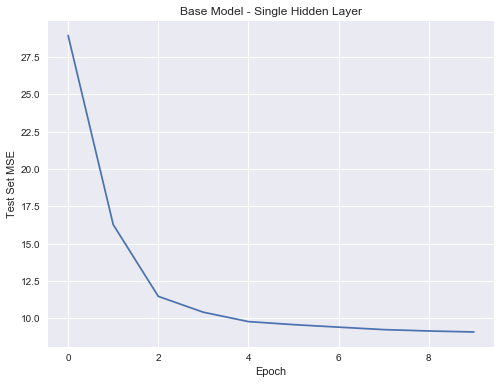

In [63]:
plt.figure(figsize=(8,6))
plt.plot(fit.history['val_loss'])
plt.title('Base Model - Single Hidden Layer')
plt.ylabel('Test Set MSE')
plt.xlabel('Epoch')
plt.savefig('base.png')
plt.show()

[745.8159561676233, 249.63091023763022, 70.83043146457801, 21.527005883301197, 11.918385204003782, 10.773583545165808, 10.693151796756148, 10.684713477180118, 10.647887182884476, 10.620345183781215]


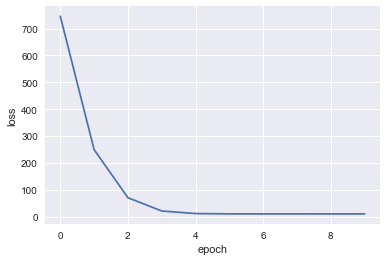

In [64]:
# BASE MODEL - larger batch

model = Sequential()
model.add(Dense(41, input_dim=41, kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=10, batch_size=10, verbose=0)

plt.plot(fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

print(fit.history['val_loss'])

[1368.890662368463, 1129.0528273809523, 779.4904955390359, 429.3317067671795, 179.01190092125717, 65.7746722941496, 33.68888313916265, 26.740794486740008, 24.290270111187784, 22.57080758023424]


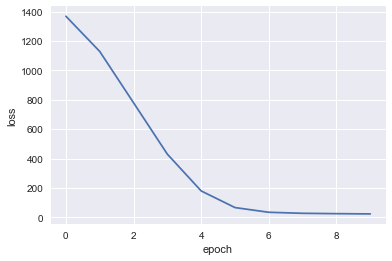

In [106]:
# BASE MODEL - larger batch

model = Sequential()
model.add(Dense(41, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=10, batch_size=50, verbose=0)

plt.plot(fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

print(fit.history['val_loss'])

[15.466462000109711, 10.60559716180575, 9.554324528402617, 9.138166978881777, 9.056980662002248, 9.162019728048115, 9.174703055316089, 9.267801020342974, 9.278386709355072, 9.209996502912368]


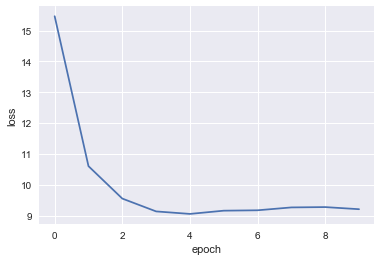

In [65]:
# BASE MODEL - smaller batch

model = Sequential()
model.add(Dense(41, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=10, batch_size=2, verbose=0)

plt.plot(fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

print(fit.history['val_loss'])

[15.451206211515126, 10.221828795675517, 9.511901196923588, 9.290914187045628, 9.187987825891549, 9.169205938064222, 9.098473759507444, 9.13888297471769, 9.067487003867114, 9.230702045807602, 9.073835206762919, 9.091891856539716, 9.395273650802519, 9.086699646348958, 9.235516889140225, 9.067324032244228, 9.098761323165325, 9.015232036526308, 9.296986295465304, 9.07709378830227, 9.341526110004, 9.191166948278745, 9.276545681496037, 9.181437369268767, 9.105732938371041, 9.08367767313077, 9.626227926447683, 9.155064642140452, 8.99685214604853, 9.104450106504848, 9.013569500821257, 9.985038638094656, 9.19113248154635, 9.11459658765519, 9.103057430687734, 9.602224419795318, 9.283660504624855, 9.33384680405994, 9.236000940198123, 9.418850443344944, 9.18761887438342, 9.115255886487518, 9.230329560325163, 9.354489511376894, 9.271241522198512, 9.48197506883492, 9.48650103628534, 9.243037263494061, 9.242710576758904, 9.155921311137982]


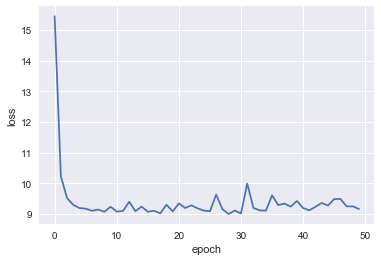

In [124]:
# BASE MODEL - smaller batch -- more epochs

model = Sequential()
model.add(Dense(41, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=50, batch_size=2, verbose=0)

plt.plot(fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

print(fit.history['val_loss'])

[15.894831637946927, 9.293103694915771, 23.901299995629966, 25.17490174170254, 19.198753240157146, 9.361162265141806, 9.902764798832589, 9.950460778207194, 9.074101310198, 14.178751668151545, 9.219762892950149, 12.307480121145444, 12.684236623802963, 9.297751477989209, 9.197938241723444, 9.11905894636297, 10.127031462938607, 10.786946080979847, 11.29348442830196, 11.636393655725078, 15.674722483368958, 9.527803246666785, 10.19551170845421, 9.04453796351037, 9.322210991463693, 15.195434343247186, 9.363579511642456, 9.251085005649903, 9.892831868865864, 10.821467258492294, 9.396824788074104, 10.141976508964486, 10.16780273687272, 11.166586146873682, 9.531669486947612, 11.323500558632572, 9.275375389728417, 13.50081529098303, 12.6151811946817, 9.435408560191693, 10.720775844288521, 17.28555918713005, 11.330879349286864, 9.808085967083366, 9.194002836739935, 9.183016739734986, 11.616448833017934, 10.253703852089084, 10.570716126435467, 10.160588186614367]


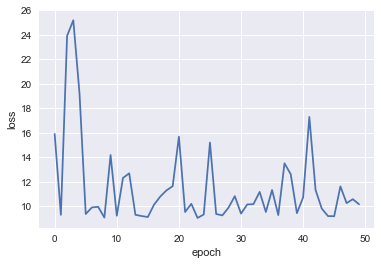

In [122]:
# BASE MODEL w/ SGD

model = Sequential()
model.add(Dense(41, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='SGD')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=50, batch_size=10, verbose=0)

plt.plot(fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

print(fit.history['val_loss'])

[22.31215708920745, 13.37539006577057, 10.65216410403349, 9.724448959843642, 9.467465373123584, 9.287546763614733, 9.242126979795444, 9.26582845660294, 9.306435061149857, 9.177316154549722]


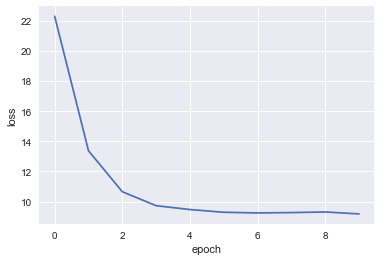

In [110]:
# DEEPER MODEL

model = Sequential()
model.add(Dense(41, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(24, kernel_initializer='normal', activation='relu'))
model.add(Dense(6, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=10, batch_size=10, verbose=0)

plt.plot(fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

print(fit.history['val_loss'])

[12.098933987066049, 9.700184169067006, 9.249200231161247, 9.028078385964543, 9.38979516507817, 9.40545061332028, 9.613139394189226, 9.207474975865715, 9.231965897135995, 9.54032552120637, 10.064520615602838, 9.910593063652922, 9.72687496650381, 9.410855148215683, 9.394586840454412, 10.201724077568572, 9.168511273098641, 9.065818219160548, 9.133705765110294, 9.474595391020483, 9.170956392576095, 9.314932565097095, 9.273343139562478, 9.756684087571644, 10.080930094329679]


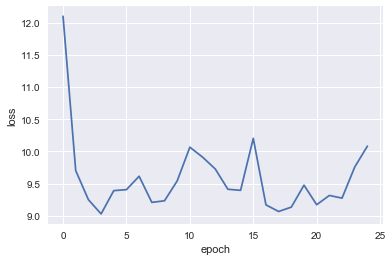

In [126]:
# DEEPER MODEL

model = Sequential()
model.add(Dense(41, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(Dense(16, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=25, batch_size=5, verbose=0)

plt.plot(fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

print(fit.history['val_loss'])

[70.06620381154171, 21.58572376666426, 15.39868146546033, 11.916533549626669, 10.549649277511907, 10.013468401772636, 9.633190352900499, 9.497734909965878, 9.36355877733555, 9.261879496022958]


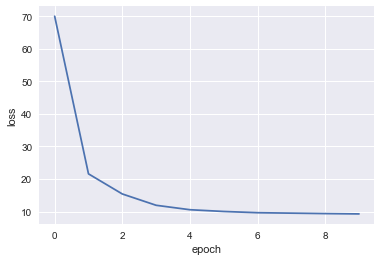

In [131]:
# BASE MODEL - WIDER

model = Sequential()
model.add(Dense(64, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=10, batch_size=10, verbose=0)

plt.plot(fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

print(fit.history['val_loss'])

[18.66006293264376, 11.231421285746048, 9.806237255634905, 9.52075531612448, 9.680705689248585, 9.093916471312646, 9.160250017432128, 9.00352398554484, 9.274614538667965, 9.057730684475024]


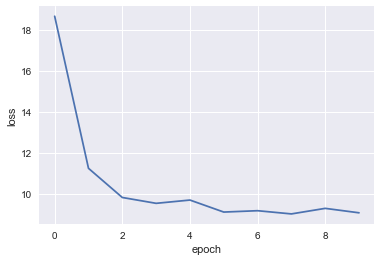

In [132]:
# WIDER MODEL

model = Sequential()
model.add(Dense(64, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=10, batch_size=10, verbose=0)

plt.plot(fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

print(fit.history['val_loss'])

[15.079423382168724, 10.100318984920476, 9.70583527307121, 9.258768870717002, 9.043234674298034, 9.083512790754538, 9.123245343059098, 9.169886228989581, 9.231447684521578, 9.062470249578256]


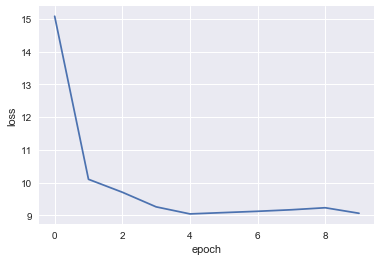

In [127]:
# WIDER MODEL

model = Sequential()
model.add(Dense(100, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=10, batch_size=10, verbose=0)

plt.plot(fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

print(fit.history['val_loss'])

[9.77597834463833, 9.569014339219956, 9.211164738045257, 9.738904485897143, 9.89689403326333, 9.4072566583854, 9.724925290970575, 9.890614506338729, 9.437932490491542, 9.355672133212186]


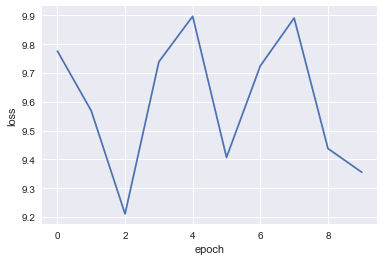

In [138]:
# MUCH WIDER MODEL

model = Sequential()
model.add(Dense(500, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=10, batch_size=10, verbose=0)

plt.plot(fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

print(fit.history['val_loss'])

[9.759465780511473, 10.108889664111494, 9.514871402034776, 9.251292785039317, 10.754624300567928, 9.345765420113102, 9.704117271912816, 9.027781620872569, 13.286130019150624, 9.711004578443815, 9.39189199633947, 9.606317016161775, 9.87497945089324, 10.628797234969886, 9.435852843341829, 9.720372546408452, 10.584764839032172, 9.511696282194508, 9.437091068713768, 9.687865613013201]


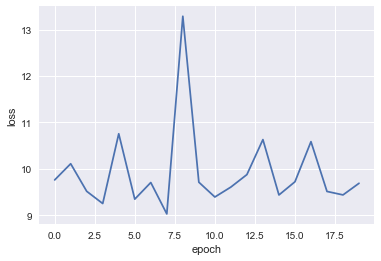

In [134]:
# WIDER MODEL w/ SMALLER BATCH

model = Sequential()
model.add(Dense(100, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=20, batch_size=2, verbose=0)

plt.plot(fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

print(fit.history['val_loss'])

[12.277453145202326, 10.04624213572262, 9.9805836434267, 9.899878621912327, 9.173260344534505, 9.206144194213712, 10.439240106919996, 10.114316757033471, 11.66457529781627, 9.060270466772067, 9.12059581117565, 9.241936660948253, 10.179224834150197, 9.899284573639331, 9.439412979852586, 9.292869766553244, 9.64386390504383, 9.292279561360678, 10.391392745128295, 10.05403686299616]


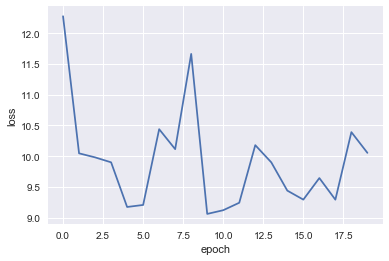

In [130]:
# WIDER + DEEPER

model = Sequential()
model.add(Dense(100, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(Dense(16, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
fit = model.fit(X_df, labels, validation_split=0.2, epochs=20, batch_size=10, verbose=0)

plt.plot(fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

print(fit.history['val_loss'])

In [137]:
### SCALED INPUTS

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=10, batch_size=10, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=7, random_state=7)
results = cross_val_score(pipeline, X_df, labels, cv=kfold)
print("%.2f (%.2f) MSE" % (results.mean(), results.std()))

-13.22 (3.38) MSE
